In [328]:
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
import os

import cv2
from natsort import natsorted
from skimage.registration import phase_cross_correlation
from skimage.registration import optical_flow_tvl1, optical_flow_ilk
from skimage.transform import warp
from scipy import ndimage as scp
from tqdm import tqdm
%matplotlib inline
from statsmodels.tsa.stattools import acf
import numpy as np

import pickle
from scipy.fftpack import fft2, fftshift, ifft2, fft,fftfreq
# from matplotlib.colors import hsv_to_rgb
from skimage.color import hsv2rgb as h2r

In [358]:
# with open('pickles/ANTS_sc1.pickle', 'rb') as handle:
#     regs_sc1 = pickle.load(handle)

# with open('pickles/ANTS_sc1_50.pickle', 'rb') as handle:
#     regs_sc1_early = pickle.load(handle)

with open('pickles/ANTS_sc1_merged.pickle', 'rb') as handle:
    regs_sc1 = pickle.load(handle)

with open('pickles/ANTS_sc2_merged.pickle', 'rb') as handle:
    regs_sc2 = pickle.load(handle)

In [359]:
regs_sc1 = np.array(regs_sc1)
# regs_sc1_early = np.array(regs_sc1_early)

# regs_sc2 = np.array(regs_sc2)

In [331]:
def gen_liv(arr):
    def liv_calc(pp):
        return(10*(np.log10(pp+1)))
    log_pics = list(map(liv_calc,arr))
    arrays_np = np.array(log_pics)
    average_across_arrays = np.mean(arrays_np, axis=0)

    liv_mask = np.zeros_like(average_across_arrays)
    for j in tqdm(range(len(log_pics))):
        liv_mask += (log_pics[j] - average_across_arrays)**2
    liv_mask/=len(log_pics)

    return liv_mask , log_pics

In [6]:
def gen_ocds(log_arr):
    for k in range(log_arr.shape[0]):
        log_arr[k] = log_arr[k]/np.max(log_arr[k])
    OCDS_mask = np.zeros((2,log_arr.shape[1],log_arr.shape[2]))
    # def autocorrelation(signal):
    #     signal = signal.astype(np.float64)
    #     n = len(signal)
    #     acf = np.zeros(n)
    #     for tau in range(n):
    #         acf[tau] = np.sum(signal[:n-tau] * signal[tau:n])  # Slice up to n (exclusive)
    #     return acf

    for i in tqdm(range(log_arr.shape[1])):
        for j in range(log_arr.shape[2]):
            temp_cov = log_arr[:,i,j]
            # corrs = autocorrelation(temp_cov)
            corrs = acf(temp_cov,nlags = len(temp_cov),fft =True)
            corrs_e = corrs[:50].copy()
            corrs_l = corrs[300:].copy()

            slope_e, intercept = np.polyfit(range(len(corrs_e)),np.array(corrs_e),deg=1)
            slope_l, intercept = np.polyfit(range(len(corrs_l)),np.array(corrs_l),deg=1)

            if not np.isnan(slope_e):
                OCDS_mask[0,i,j] = slope_e
            if not np.isnan(slope_l):
                OCDS_mask[1,i,j] = slope_l
    return OCDS_mask

# def gen_ocds(log_arr_early,log_arr_late):
#     OCDS_mask = np.zeros((2,log_arr_early.shape[1],log_arr_early.shape[2]))
#     def autocorrelation(signal):
#         signal = signal.astype(np.float64)
#         n = len(signal)
#         acf = np.zeros(n)
#         for tau in range(n):
#             acf[tau] = np.sum(signal[:n-tau] * signal[tau:n])  # Slice up to n (exclusive)
#         return acf
    

#     for i in tqdm(range(log_arr_early.shape[1])):
#         for j in range(log_arr_early.shape[2]):
#             gg_e = autocorrelation(log_arr_early[:,i,j])
#             gg_l = autocorrelation(log_arr_late[:,i,j])
#             slp_e = np.polyfit(range(len(gg_e)),np.array(gg_e),deg=1)[0]
#             slp_l = np.polyfit(range(len(gg_l)),np.array(gg_l),deg=1)[0]
#             OCDS_mask[0,i,j] = slp_e
#             OCDS_mask[1,i,j] = slp_l

#             # temp_cov_e = log_arr_early[:,i,j]
#             # temp_cov_l = log_arr_late[:,i,j]
#             # corr_vals_e = acf(temp_cov_e,nlags = len(temp_cov),fft =True)
#             # corr_vals_l = acf(temp_cov_l,nlags = len(temp_cov),fft =True)
#             # slope_e, intercept = np.polyfit(range(len(corr_vals_e)),np.array(corr_vals_e),deg=1)
#             # slope_l, intercept = np.polyfit(range(len(corr_vals_l)),np.array(corr_vals_l),deg=1)
#             # if slope_e<0:
#             #     OCDS_mask[0,i,j] = slope_e
#             # # else:
#             # #     OCDS_mask[0,i,j] = 0
#             # if slope_l<0:
#             #     OCDS_mask[1,i,j] = slope_l
#             # # else:
#             # #     OCDS_mask[1,i,j] = 0
    
#     return OCDS_mask

In [332]:
def get_rgb(mask,img):

    h = (((mask)/np.max(mask)) * 90).astype(np.float32)
    s = np.full_like(mask,255)
    # v = regs_sc2[49].astype(np.float32) / np.max(regs_sc2[49])
    v = img.astype(np.float32).copy()
    # v[800:] = 50
    hsv_img = np.dstack((h,s,v))
    # rgb_image = hsv2rgb(hsv_img)
    rgb_image = cv2.cvtColor(hsv_img.astype(np.float32), cv2.COLOR_HSV2RGB)
    return rgb_image

In [8]:
from skimage.color import hsv2rgb

In [360]:
liv_mask_sc1, log_sc1 = gen_liv(regs_sc1)
# liv_mask_sc2, log_sc2 = gen_liv(regs_sc2)

log_sc1 = np.array(log_sc1)
# log_sc2 = np.array(log_sc2)

100%|██████████| 500/500 [00:00<00:00, 6633.79it/s]


In [806]:
# _ , log_sc1_early = gen_liv(regs_sc1_early)
# OCDS_sc1 = gen_ocds(np.array(log_sc1_early),np.array(log_sc1)[250:])
OCDS_sc1 = gen_ocds(np.array(log_sc1))


# OCDS_sc2 = gen_ocds(np.array(log_sc2))

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/akapatil/opt/anaconda3/envs/ImageProc_2/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:693: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
100%|██████████| 1000/1000 [01:11<00:00, 13.91it/s]


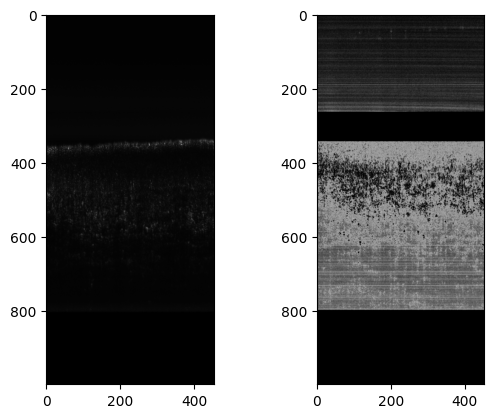

In [422]:
plt.subplot(1,2,1)
plt.imshow(liv_mask_sc1,cmap='gray')

plt.subplot(1,2,2)
plt.imshow(liv_mask_sc2,cmap='gray')


In [420]:
def norm_max(pp):
    return((pp-np.min(pp))/(np.min(pp)+np.max(pp)))
norm_pics_sc1 = np.array(list(map(norm_max,regs_sc1)))
# norm_pics_sc2 = list(map(norm_max,regs_sc2))

In [421]:
liv_mask_sc1, log_sc1 = gen_liv(norm_pics_sc1)

100%|██████████| 500/500 [00:00<00:00, 5898.88it/s]


In [431]:
mm=[]
for k in range(0,len(norm_pics_sc1)-1):
    mm.append(correlate2d(norm_pics_sc1[k][i-5:i+6,j-5:j+6],norm_pics_sc1[250][i-5:i+6,j-5:j+6],mode='valid')[0][0])

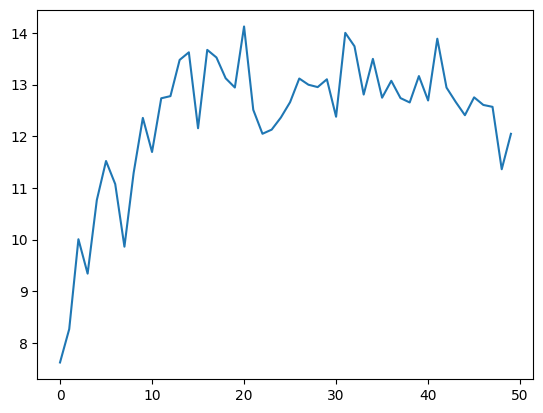

In [434]:
plt.plot(mm[:50])

In [355]:
from sklearn.metrics.cluster import normalized_mutual_info_score as nmis

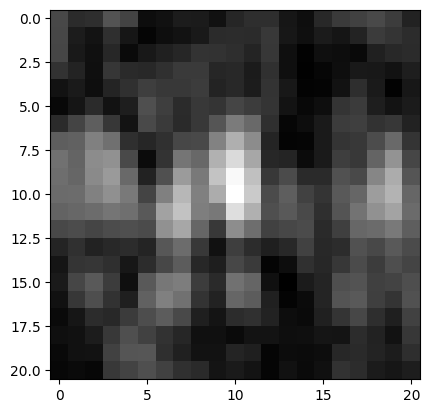

In [430]:
i = 483
j = 161
plt.imshow(norm_pics_sc1[400][i-10:i+11,j-10:j+11],cmap='gray')

In [199]:
correlate2d(norm_pics_sc1[0][i-5:i+6,j-5:j+6],norm_pics_sc1[250][i-5:i+6,j-5:j+6],mode='valid')

array([[8.145173]], dtype=float32)

In [101]:
nmis(norm_pics_sc1[249][i-5:i+6,j-5:j+6].flatten(),norm_pics_sc1[250][i-5:i+6,j-5:j+6].flatten())

/Users/akapatil/opt/anaconda3/envs/ImageProc_2/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


0.9583968863762025

In [68]:
from scipy.signal import correlate2d,correlate

In [435]:
def acc(log_arr):
    # pad_logsc1 = np.pad(log_arr,(1,1))[1:-1]
    pad_logsc1 = log_arr
    maskkk = np.zeros((2,pad_logsc1[0].shape[0],pad_logsc1[0].shape[1]))
    for i in tqdm(range(5,pad_logsc1.shape[1]-5)):
        for j in range(5,pad_logsc1.shape[2]-5):
            mm = []
            # for k in range(0,pad_logsc1.shape[0]):
            #     mm.append(pad_logsc1[k,i,j])
            for k in range(0,pad_logsc1.shape[0]-1):
                mm.append(correlate2d(pad_logsc1[k][i-5:i+6,j-5:j+6],pad_logsc1[k+1][i-5:i+6,j-5:j+6],mode='valid')[0][0])
            e_cumsum = mm[:50]
            l_cumsum = mm[300:]
            slp_e = np.polyfit(range(len(e_cumsum)),e_cumsum,deg=1)[0]
            maskkk[0,i,j] = slp_e
            slp_l = np.polyfit(range(len(l_cumsum)),l_cumsum,deg=1)[0]
            maskkk[1,i,j] = slp_l
    maskkk[np.isnan(maskkk)]=0
    return maskkk


In [343]:
from skimage.metrics import normalized_mutual_information as nmi
from skimage.metrics import normalized_root_mse as nrm

In [436]:
mask_sc1 = acc(norm_pics_sc1)
# mask_sc1[np.isnan(mask_sc1)]=0
# mask_sc2 = acc(log_sc2)
# mask_sc2[np.isnan(mask_sc2)]=0

100%|██████████| 990/990 [13:08<00:00,  1.26it/s]


In [370]:
neg_mask = -mask_sc1.copy()

In [371]:
maskkk_adj_sc1 = (neg_mask-np.min(neg_mask))/np.max((neg_mask-np.min(neg_mask)))
# maskkk_adj_sc2 = (mask_sc2-np.min(mask_sc2))

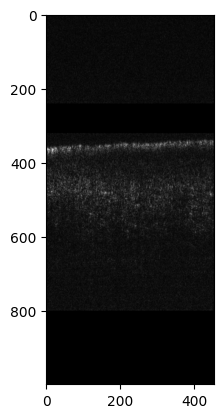

In [387]:
plt.imshow(regs_sc1[300],cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


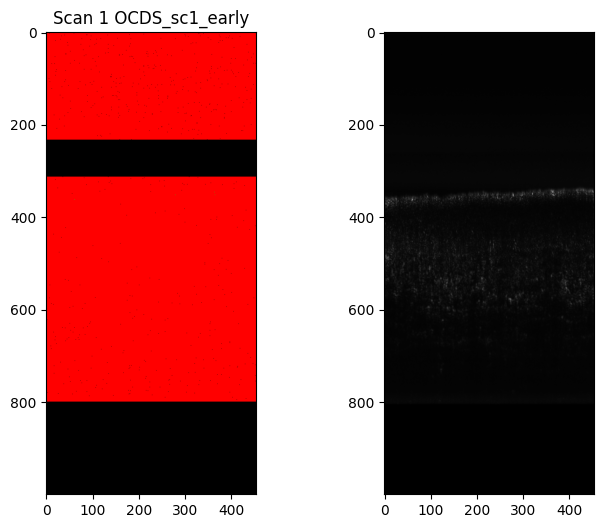

In [428]:
fig1 = plt.figure(figsize=(8,6))
# plt.subplot(1,3,2)
rgb_image_liv_sc1 = get_rgb(liv_mask_sc1,regs_sc1[250])
# rgb_image_liv_sc1[rgb_image_liv_sc1<0]=0

axx1 = fig1.add_subplot(1,2,1)
axx1.imshow(rgb_image_liv_sc1)
axx1.set_title('Scan 1 OCDS_sc1_early')

axx2 = fig1.add_subplot(1,2,2)
axx2.imshow(liv_mask_sc1,cmap='gray')

plt.show()
# fig1.savefig('Scan 1 OCDS_sc1_early.png',dpi=800)

NameError: name 'maskkk_adj_sc2' is not defined

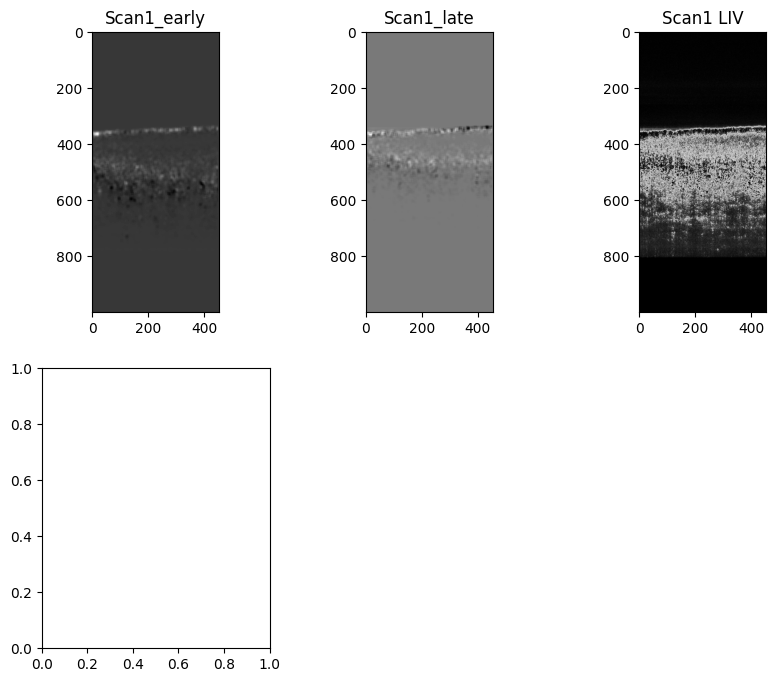

In [278]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(2,3,1)
# ax1.add_subplot(2,3,1)
ax1.imshow(maskkk_adj_sc1[0],cmap='gray')
ax1.set_title('Scan1_early')

ax2 = fig.add_subplot(2,3,2)
ax2.imshow(maskkk_adj_sc1[1],cmap='gray')
ax2.set_title('Scan1_late')

ax3 = fig.add_subplot(2,3,3)
ax3.imshow(liv_mask_sc1,cmap='gray')
ax3.set_title('Scan1 LIV')

ax4 = fig.add_subplot(2,3,4)
ax4.imshow(maskkk_adj_sc2[0],cmap='gray')
ax4.set_title('Scan2_early')

ax5 = fig.add_subplot(2,3,5)
ax5.imshow(maskkk_adj_sc2[1],cmap='gray')
ax5.set_title('Scan2_late')

ax6 = fig.add_subplot(2,3,6)
ax6.imshow(liv_mask_sc2,cmap='gray')
ax6.set_title('Scan2 LIV')


fig.savefig('full_figure.png',dpi=1000)

In [56]:
# h = ((liv_mask)/np.max(liv_mask)) * 180
# s = np.full_like(liv_mask,1) * 255
# # v = regs[49].astype(np.float32) / np.max(regs[49])
# v = regs_sc1[0]


# hsv_img = np.dstack((h,s,v))
# rgb_image = cv2.cvtColor(hsv_img.astype(np.uint8), cv2.COLOR_HSV2RGB)


# part2

In [1064]:
with open('pickles/ANTS_sc2_merged.pickle', 'rb') as handle:
    regs_sc2 = pickle.load(handle)

In [1067]:
def gen_liv(arr):
    def liv_calc(pp):
        return(10*(np.log10(pp+1)))
    log_pics = list(map(liv_calc,arr))
    arrays_np = np.array(log_pics)
    average_across_arrays = np.mean(arrays_np, axis=0)

    liv_mask = np.zeros_like(average_across_arrays)
    for j in tqdm(range(len(log_pics))):
        liv_mask += (log_pics[j] - average_across_arrays)**2
    liv_mask/=len(log_pics)

    return liv_mask , log_pics

In [1066]:
regs_sc2 = np.array(regs_sc2)

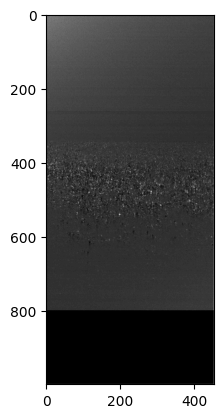

In [ ]:
plt.imshow((liv_mask_2)/np.max(liv_mask_2),cmap='gray')

In [16]:
h = ((liv_mask_2)/np.max(liv_mask_2)) * 180
s = np.full_like(liv_mask_2,1) * 255
# v = regs_sc2[49].astype(np.float32) / np.max(regs_sc2[49])
# v *=255
v = regs_sc2[490]


hsv_img = np.dstack((h,s,v))
rgb_image = cv2.cvtColor(hsv_img.astype(np.uint8), cv2.COLOR_HSV2RGB)


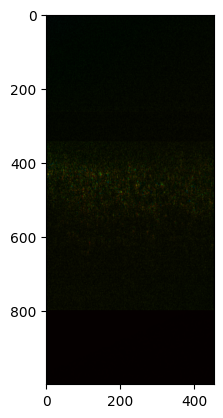

In [17]:
plt.imshow(rgb_image)
# plt.imsave('ooo2.png',rgb_image)

In [69]:
regs_sc1_log = np.array(regs_sc1_log)

In [78]:
mm = []
for i in range(regs_sc1.shape[0]):
    mm.append(np.mean(regs_sc1[i][483,163]))

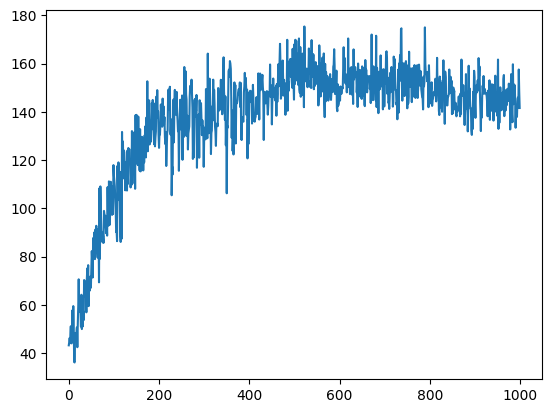

In [79]:
plt.plot(mm)

In [20]:
plt.plot(acf(regs_sc1_log[:200,483,163],nlags = len(regs_sc1_log[:,0,0]),fft =True))

NameError: name 'regs_sc1_log' is not defined

In [15]:
regs_sc2_log = np.array(regs_sc2_log)

In [52]:
regs_sc2_log = list(map(liv_calc,regs_sc2))
OCDS_sc2 = gen_ocds(np.array(regs_sc2_log))

KeyboardInterrupt: 

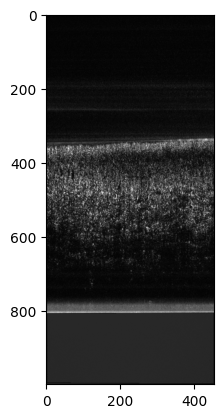

In [53]:
plt.imshow(OCDS_sc1[0],cmap='gray')

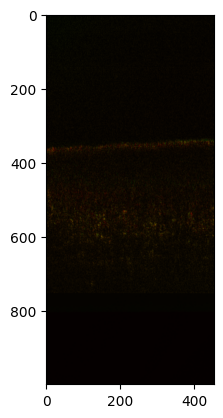

In [30]:
rgb_image_liv_sc1 = get_rgb(liv_mask_sc1,regs_sc1[0])
# rgb_image_liv_sc1 = rgb_image_liv_sc1[:, :, [1, 0, 2]] 
plt.imshow(rgb_image_liv_sc1)
plt.imsave('ooop.png',rgb_image_liv_sc1)

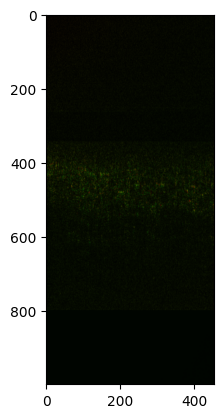

In [28]:
rgb_image_liv_sc2 = get_rgb(liv_mask_sc2,regs_sc2[900])
rgb_image_liv_sc2 = rgb_image_liv_sc2[:, :, [1, 0, 2]]
plt.imshow(rgb_image_liv_sc2)
plt.imsave('ooop.png',rgb_image_liv_sc2)

### OCDS_E

In [54]:
rgb_image_ocds_e_sc1 = get_rgb(OCDS_sc1[0],regs_sc1[500])
plt.imshow(rgb_image_ocds_e_sc1)
plt.imsave('rgb_image_ocds_e_sc1.PNG',rgb_image_ocds_e_sc1)
plt.clf()

rgb_image_ocds_e_sc2 = get_rgb(OCDS_sc2[0],regs_sc2[500])
plt.imshow(rgb_image_ocds_e_sc2)
plt.imsave('rgb_image_ocds_e_sc2.PNG',rgb_image_ocds_e_sc2)
plt.clf()

<Figure size 640x480 with 0 Axes>

### OCDS_L

In [39]:
rgb_image_ocds_l_sc1 = get_rgb(OCDS_sc1[1],regs_sc1[700])
plt.imshow(rgb_image_ocds_l_sc1)
plt.imsave('rgb_image_ocds_l_sc1.PNG',rgb_image_ocds_l_sc1)
plt.clf()

rgb_image_ocds_l_sc2 = get_rgb(OCDS_sc2[1],regs_sc2[700])
plt.imshow(rgb_image_ocds_l_sc2)
plt.imsave('rgb_image_ocds_l_sc2.PNG',rgb_image_ocds_l_sc2)
plt.clf()

<Figure size 640x480 with 0 Axes>

### OCDS_All

In [40]:
rgb_image_ocds_all_sc1 = get_rgb(OCDS_sc1[2],regs_sc1[700])
plt.imshow(rgb_image_ocds_all_sc1)
plt.imsave('rgb_image_ocds_all_sc1.PNG',rgb_image_ocds_all_sc1)
plt.clf()

rgb_image_ocds_all_sc2 = get_rgb(OCDS_sc2[2],regs_sc2[700])
plt.imshow(rgb_image_ocds_all_sc2)
plt.imsave('rgb_image_ocds_all_sc2.PNG',rgb_image_ocds_all_sc2)
plt.clf()

<Figure size 640x480 with 0 Axes>

### LIV

In [63]:
rgb_image_liv_sc1 = get_rgb(liv_mask_sc1,regs_sc1[0])
plt.imshow(rgb_image_liv_sc1)
plt.imsave('rgb_image_liv_sc1.PNG',rgb_image_liv_sc1)
plt.clf()

rgb_image_liv_sc2 = get_rgb(liv_mask_sc2,regs_sc2[0])
plt.imshow(rgb_image_liv_sc2)
plt.imsave('rgb_image_liv_sc2.PNG',rgb_image_liv_sc2)
plt.clf()

<Figure size 640x480 with 0 Axes>

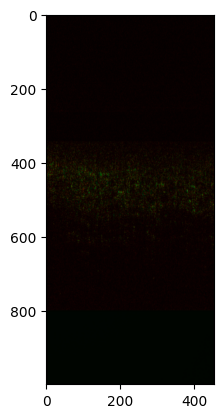

In [36]:
rgb_image_ocds_sc2 = get_rgb(OCDS_sc2[1],regs_sc2[900])
plt.imshow(rgb_image_ocds_sc2)

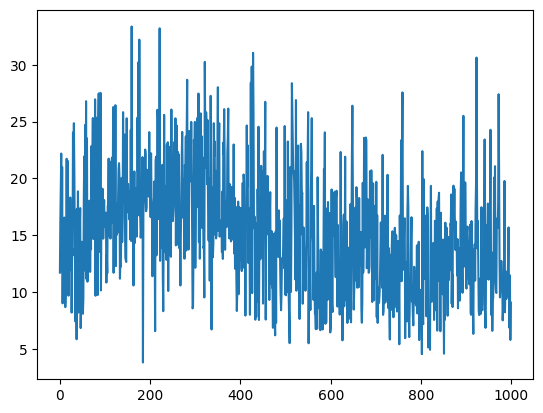

In [45]:
plt.plot(regs_sc1[:,407,68])